# NIRSpec Merged Table

Demo of full merged table of NIRSpec spectra reduced with [msaexp](http://github.com/gbrammer/msaexp).  The merged columns are taken from the database tables

- `nirspec_extractions` - Basic spectrum parameters (grating, mask, exposure time, etc.)
- `nirspec_redshifts` - Redshift fit results, emission line fluxes
- `nirspec_redshifts_manual` - Grades and comments from visual inspection
- `nirspec_integrated` - Observed- and rest-frame filters integrated through the spectra at the derived redshift
- `grizli_photometry` - Photometry and some eazy outputs of the nearest counterpart in the DJA/grizli photometric catalogs

The public spectra are shown in a large overview table at [public_prelim_v4.2.html](https://s3.amazonaws.com/msaexp-nirspec/extractions/public_prelim_v4.2.html).

In [1]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.utils.data import download_file
from astropy.cosmology import WMAP9
import astropy.units as u

import grizli
import grizli.catalog
from grizli import utils

import eazy
import msaexp

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')
print(f'msaexp version: {msaexp.__version__}')

grizli version: 1.12.12.dev5+g5896d62.d20250426
eazy-py version: 0.8.5
msaexp version: 0.9.8.dev3+ge0e3f39.d20250429


## Read the table

In [2]:
# Full table
table_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.csv.gz"
tab = utils.read_catalog(download_file(table_url, cache=True), format='csv')

In [3]:
# Column descriptions
columns_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.columns.csv"
tab_columns = utils.read_catalog(download_file(columns_url, cache=True), format='csv')

# Set column metadata
for row in tab_columns:
    c = row['column']
    if row['unit'] != '--':
        tab[c].unit = row['unit']
    if row['format'] != '--':
        tab[c].format = row['format']
    if row['description'] != '--':
        tab[c].description = row['description']

tab.info()

<GTable length=52181>
        name         dtype   unit  format                                       description                                           class     n_bad
------------------- ------- ------ ------ ---------------------------------------------------------------------------------------- ------------ -----
               file   str57                                                                                           DJA filename       Column     0
              srcid   int64                                                                                Source ID from APT plan       Column     0
                 ra float64    deg    .8f                                                                         RA from APT plan       Column     0
                dec float64    deg    .8f                                                                        Dec from APT plan       Column     0
            grating    str5                                                   

# zphot - zspec

11200


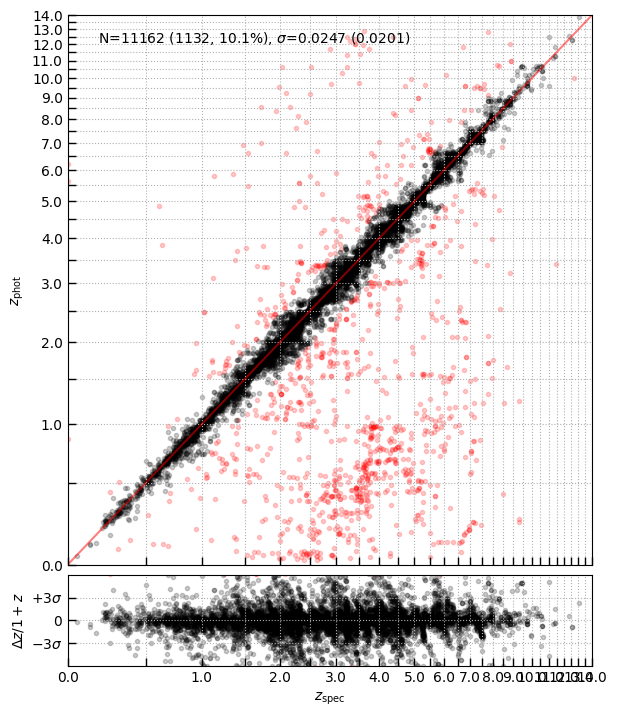

In [4]:
import eazy.utils
test = (tab['grade'] == 3) & (tab['z_phot'].filled(-1.) > 0)
test &= (tab['grating'] == 'PRISM')
print(test.sum())
_ = eazy.utils.zphot_zspec(tab['z_phot'][test], tab['z_best'][test], zmax=14)


In [25]:
# Counts by mask / program
utils.Unique(tab['root'])

   N  value     
====  ==========
 309  abell2744-castellano1-v4
 111  abell2744-ddt-v4
 230  abell2744-glass-v4
 137  aurora-gdn01-v4
 147  aurora-gdn02-v4
   9  bd-ic348-gto-v4
  25  bd-orion-gto-v4
 219  bluejay-north-v4
 223  bluejay-south-v4
  50  borg-0037m3337-v4
  38  borg-0314m6712-v4
  37  borg-0409m5317-v4
  36  borg-0440m5244-v4
  37  borg-0859p4114-v4
  45  borg-0955p4528-v4
  38  borg-1033p5051-v4
  43  borg-1437p5044-v4
  30  borg-2203p1851-v4
   5  cantalupo-filament-02-v4
 333  capers-cos01-v4
 416  capers-cos10-v4
 290  capers-cos13-v4
 372  capers-egs44-v4
 395  capers-egs47-v4
 404  capers-egs49-v4
 413  capers-egs53-v4
 324  capers-egs55-v4
 381  capers-egs61-v4
 343  capers-udsp1-v4
 299  capers-udsp2-v4
 278  capers-udsp3-v4
 168  capers-udsp5-v4
 102  cecilia-v4
 151  ceers-ddt-v4
1720  ceers-v4  
 340  cosmos-curti-v4
   1  cosmos-lae-martin-v4
 301  cosmos-transients-v4
 230  egs-mason-v4
 237  egs-nelsonx-v4
 125  excels-uds01-v4
 125  excels-uds02-v4
 135  e

## Source counts

Show magnitude, color, redshift distribution as a function of "grade":

- **Grade 3**: Robust redshift from one or more emission absorption features
- **2** Ambiguous continuum features, perhaps only one line or low confidence lines
- **1** No clear features in the spetrum to constrain the redshift
- **0** Spectrum suffers some data quality issue and should

   N  value     
====  ==========
3713          -1
  93           0
1283           1
 586           2
11200           3


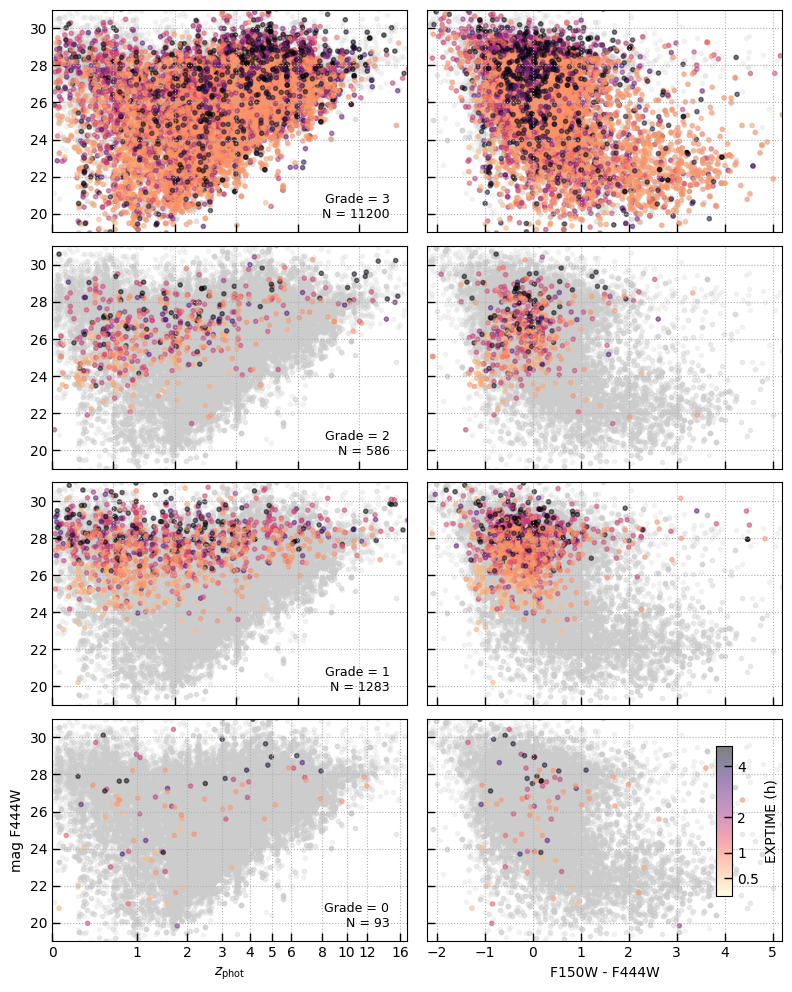

In [5]:
fig, axes = plt.subplots(4,2,figsize=(8,10), sharex=False, sharey=True)

colors = {0: 'magenta', 1: '0.5', 2: 'coral', 3: 'olive'}

# sub = is_rubies
sub = tab['ra'] > 0

sub = sub & True

sub &= tab['z_phot'].filled(-1) > 0
sub &= tab['grating'] == 'PRISM'

un = utils.Unique(tab[sub]['grade'].filled(-1))

blue = -2.5*np.log10(tab['phot_f150w_tot_1'] / tab['phot_f444w_tot_1'])

for i, c in enumerate([3,2,1,0]):

    kws = dict(
        c = np.sqrt(tab[sub][un[c]]['exptime']), vmin=900**0.5, vmax=(5*3600)**0.5, cmap='magma_r',
        # c = 'magenta',
        alpha=0.5, 
        label=f'Grade = {c}',
    )
    
    ax = axes[i][1]
    ax.scatter(blue,
               23.9 - 2.5*np.log10(tab['phot_f444w_tot_1']),
               c='0.8',
               alpha=0.2, 
               label=f'Grade = {c}',
    )

    sc = ax.scatter(blue[sub][un[c]],
               23.9 - 2.5*np.log10(tab[sub]['phot_f444w_tot_1'])[un[c]],
               **kws,
    )
    ax.grid()

    if i < 3:
        ax.set_xticklabels([])

    ax.set_xlim(-2.2, 5.2)
        
    ax = axes[i][0]
    
    ax.scatter(np.log(1+tab['z_phot']),
               23.9 - 2.5*np.log10(tab['phot_f444w_tot_1']),
               c='0.8',
               alpha=0.2, 
               label=f'Grade = {c}' + '\n' + f'N = {un[c].sum()}',
    )

    ax.scatter(np.log(1+tab[sub]['z_phot'][un[c]]),
               23.9 - 2.5*np.log10(tab[sub]['phot_f444w_tot_1'])[un[c]],
               **kws,
    )
    
    ax.grid()
    ax.text(
        0.95, 0.05,
        # f'Grade = {c}',
        f'Grade = {c}' + '\n' + f'N = {un[c].sum()}',
        ha='right', va='bottom', fontsize=9, transform=ax.transAxes)

    if i < 3:
        ax.set_xticklabels([])
    
    xt = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16]
    ax.set_xlim(0, np.log(1+17))

ax.set_ylabel('mag F444W')

cax = fig.add_axes

cax = fig.add_axes((0.9, 0.1, 0.02, 0.15))
cb = plt.colorbar(sc, cax=cax, orientation='vertical')
ct = [0.5, 1, 2, 4]
cb.set_ticks(np.sqrt(np.array(ct)*3600))
cb.set_ticklabels(ct)
cb.set_label('EXPTIME (h)')

ax.set_ylim(19, 31)

ax.set_xticks(np.log(1+np.array(xt)))
ax.set_xticklabels(xt)
ax.set_xlabel(r'$z_\mathrm{phot}$')

ax = axes[3][1]

ax.set_xlabel('F150W - F444W')

# ax.legend()

fig.tight_layout(pad=1)


## PRISM sample for comparision

In [6]:
sample = (tab['grade'] == 3) & (tab['grating'] == 'PRISM')
sample &= tab['z_best'] < 7
sample &= tab['rest_153_frac'] > 0.8
sample &= tab['rest_154_frac'] > 0.8
sample &= tab['rest_155_frac'] > 0.8


## Interpolate Halpha EQW from nearby filters

Use interpolated EQW


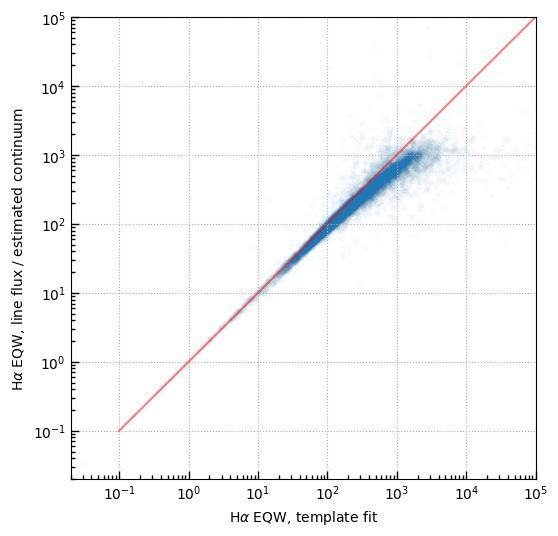

In [7]:
import eazy.filters
RES = eazy.filters.FilterFile()

fb, fr = 415, 416
#fb, fr = 155, 416
wb = RES[fb].pivot
wr = RES[fr].pivot

flamb = (1*u.microJansky).to(u.erg/u.second/u.cm**2/u.Angstrom, equivalencies=u.spectral_density(wb*u.Angstrom))
flamr = (1*u.microJansky).to(u.erg/u.second/u.cm**2/u.Angstrom, equivalencies=u.spectral_density(wr*u.Angstrom))

whtb = (1 - np.abs(wb - 6564.)/(wr-wb))# *flamb
whtr = (1 - np.abs(wr - 6564.)/(wr-wb))# *flamr

interp_flux = tab[f'rest_{fb}_flux']*whtb*flamb + tab[f'rest_{fr}_flux']*whtr*flamr

eqw = ((tab['line_ha_nii']*1.e-20*u.erg/u.second/u.cm**2 / (interp_flux / (1+tab['zline'])**1))).value

plt.scatter(
    (np.maximum(tab['eqw_ha_nii'], -100) / (1+tab['zline'])**1)[sample],
    eqw[sample], alpha=0.02
)
plt.plot([0.1, 1e7], [0.1, 1e7], color='r', alpha=0.5)
plt.loglog()
plt.grid()
plt.xlim(0.02, 1.e5); plt.ylim(0.02, 1.e5)
plt.xlabel(r'H$\alpha$ EQW, template fit')
plt.ylabel(r'H$\alpha$ EQW, line flux / estimated continuum')

if 1:
    print('Use interpolated EQW')
    eqw_lim = np.maximum(tab['line_ha_nii'], tab['line_ha_nii_err']*2) * 1.e-20*u.erg/u.second/u.cm**2 / (interp_flux / (1+tab['zline']))
    is_eqw_lim = tab['line_ha_nii_err']*2 > tab['line_ha_nii']
    eqw[is_eqw_lim] = eqw_lim.value[is_eqw_lim]
    tab['ha_eqw_with_limits'] = eqw
    tab['ha_eqw_is_limit'] = is_eqw_lim
    

# Rest-frame colors

In [8]:
UV = -2.5*np.log10(tab['phot_restU'] / tab['phot_restV'])
VJ = -2.5*np.log10(tab['phot_restV'] / tab['phot_restJ'])

UVs = -2.5*np.log10(tab['rest_153_flux'] / tab['rest_155_flux'])
BVs = -2.5*np.log10(tab['rest_154_flux'] / tab['rest_155_flux'])
VJs = -2.5*np.log10(tab['rest_155_flux'] / tab['rest_161_flux'])

dL = WMAP9.luminosity_distance(tab['zrf']).to('cm')
fV = (tab['rest_155_flux']*u.microJansky).to(
    u.erg/u.second/u.cm**2/u.Angstrom,
    equivalencies=u.spectral_density(5500.*(1+tab['zrf'])*u.Angstrom)
)
LV = (fV * 5500. * u.Angstrom * (1 + tab['zrf']) * 4 * np.pi * dL**2).to(u.Lsun)

Text(0, 0.5, '$\\log M = \\log L_V + \\log M/L_V$\n$\\log M/L_V \\propto (B-V)$')

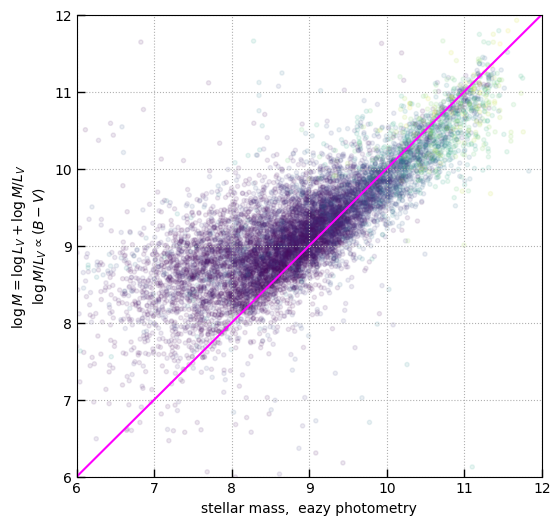

In [9]:
# Crude M/Lv ~ B-V from Taylor et al. 2009 for getting a quick stellar mass from the spectrum

log_MLv = -0.734 + 1.404 * (BVs + 0.084)
MassV = log_MLv + np.log10(LV.value)

tab['Mass'] = MassV
tab['Mass'].format = '.3f'

plt.scatter(np.log10(tab['phot_mass'][sample]), MassV[sample], alpha=0.1, c=tab['phot_Av'][sample])
plt.plot([5, 12], [5, 12], color='magenta')
plt.grid()
plt.xlim(6, 12)
plt.ylim(6, 12)
plt.xlabel('stellar mass,  eazy photometry')
plt.ylabel(r'$\log M = \log L_V + \log M/L_V$' + '\n' + r'$\log M/L_V \propto (B-V)$')

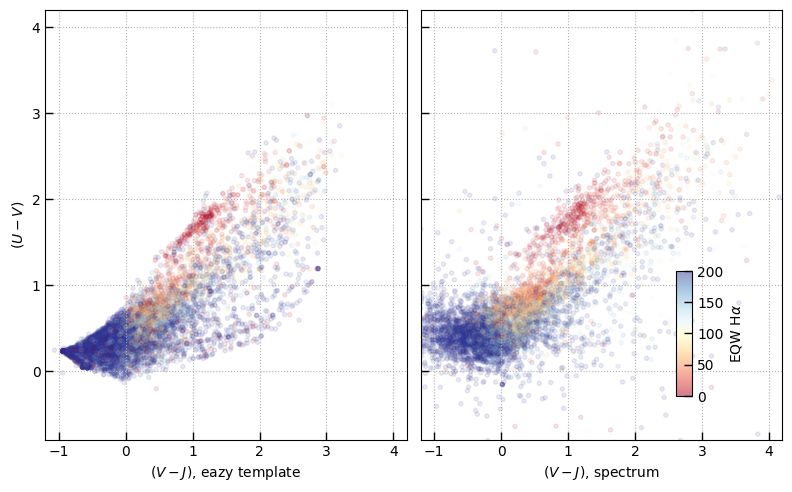

In [11]:
fig, axes = plt.subplots(1,2,figsize=(8,5), sharex=True, sharey=True)

axes[0].scatter(
    VJ[sample], UV[sample], alpha=0.1,
    c=tab['ha_eqw_with_limits'][sample], vmin=0, vmax=200, cmap='RdYlBu'
)
axes[0].set_xlabel(r'$(V-J)$' + ', eazy template')
axes[0].set_ylabel(r'$(U-V)$')

axes[1].scatter(
    VJs[sample], UVs[sample], alpha=0.1,
    c=tab['ha_eqw_with_limits'][sample], vmin=0, vmax=200, cmap='RdYlBu'
)

sc = axes[1].scatter(
    VJs[sample][:1], UVs[sample][:1], alpha=0.5,
    c=tab['ha_eqw_with_limits'][sample][:1], vmin=0, vmax=200, cmap='RdYlBu'
)

axes[1].set_xlabel(r'$(V-J)$' + ', spectrum')

for ax in axes:
    ax.set_xlim(-1.2, 4.2)
    ax.set_ylim(-0.8, 4.2)
    ax.grid()

cax = fig.add_axes((0.85, 0.2, 0.02, 0.25))
cb = plt.colorbar(sc, cax=cax, orientation='vertical')
cb.set_label(r'EQW H$\alpha$')

fig.tight_layout(pad=1)

Text(0, 0.5, 'rough stellar mass')

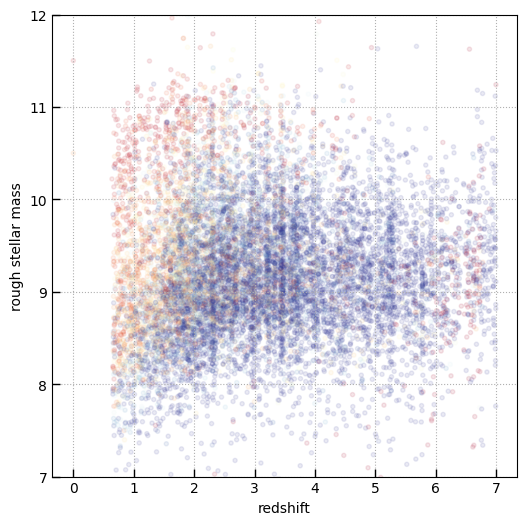

In [12]:
plt.scatter(
    tab['z_best'][sample],
    # np.log10(tab['phot_mass'])[sample],
    tab['Mass'][sample],
    alpha=0.1,
    c=tab['ha_eqw_with_limits'][sample], vmin=0, vmax=200, cmap='RdYlBu'
)
plt.ylim(7, 12)
plt.grid()
plt.xlabel('redshift')
plt.ylabel('rough stellar mass')

In [13]:
RGB_URL = "https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra}%2C{dec}"
tab['metafile'] = [m.split('_')[0] for m in tab['msamet']]
SLIT_URL = "https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra}%2C{dec}&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile={metafile}"
FITS_URL = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"

tab['Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        RGB_URL.format(**row['ra','dec'])
    )
    for row in tab
]

tab['Slit_Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        SLIT_URL.format(**row['ra','dec','metafile'])
    )
    for row in tab
]

tab['Spectrum_fnu'] = [
    "<img src=\"{0}\" height=200px>".format(
        FITS_URL.format(**row['root','file']).replace('.spec.fits', '.fnu.png')
    )
    for row in tab
]

tab['Spectrum_flam'] = [
    "<img src=\"{0}\" height=200px>".format(
        FITS_URL.format(**row['root','file']).replace('.spec.fits', '.flam.png')
    )
    for row in tab
]


In [15]:
massive = sample & (tab['z_best'] > 2.) & (MassV > 10.8)

tab['root','file','z_best','Mass','ha_eqw_with_limits','Thumb','Slit_Thumb','Spectrum_fnu', 'Spectrum_flam'][massive].write_sortable_html(
    '/tmp/massive.html',
    max_lines=1000,
    localhost=False,
)

## Read a spectrum

![ruby](https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_75646.fnu.png)

In [16]:
import msaexp.spectrum
row = tab[tab['file'] == 'rubies-egs61-v4_prism-clear_4233_75646.spec.fits'][0]
spec = msaexp.spectrum.SpectrumSampler(FITS_URL.format(**row))

In [18]:
spec.spec.info

<GTable length=473>
    name     dtype  unit                description                   class     n_bad
----------- ------- ---- ----------------------------------------- ------------ -----
       wave float64                                                      Column     0
       flux float64                                                      Column     0
        err float64                                                      Column     0
        sky float64  uJy                                           MaskedColumn     5
  path_corr float64                                                MaskedColumn     5
       npix float64                                                      Column     0
   flux_sum float64                                                      Column     0
profile_sum float64                                                      Column     0
    var_sum float64                                                      Column     0
       corr float64               

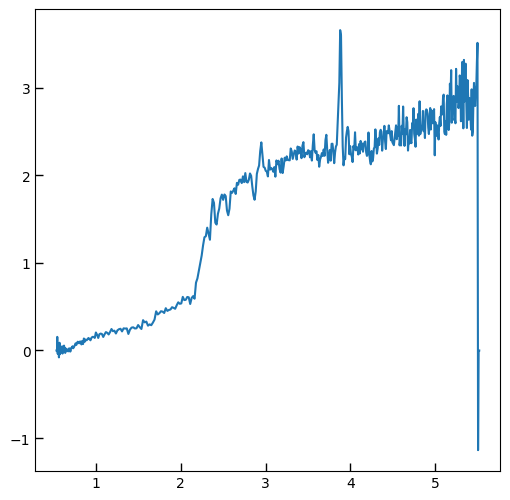

In [19]:
plt.plot(spec['wave'], spec['flux'])

In [22]:
# Thumbnail API

from IPython.display import Image
print(RGB_URL.format(**row))
Image(url=RGB_URL.format(**row), height=300, width=300)


https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.91554591%2C52.94901831


In [23]:
print(SLIT_URL.format(**row))
Image(url=SLIT_URL.format(**row), height=300, width=300)

https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.91554591%2C52.94901831&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233006001
